In [1]:
import umap
import pandas as pd
import numpy as np
import itertools as it
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

/albedo/home/yvjennig/.conda/envs/cluster_validation/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/albedo/home/yvjennig/.conda/envs/cluster_validation/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/albedo/home/yvjennig/.conda/envs/

In [2]:
import dask
from dask.distributed import Client

In [3]:
@dask.delayed
def compute_scores(df, compute_scores_on=None, algorithm="kmeans", iterations=10, clustering_on="original", scores_on="original"):
    if compute_scores_on is not None:
        X = compute_scores_on.copy()
    else:
        X = df.copy()

    hyp_dict = hyps[algorithm]
    hyp_combinations = list(it.product(*hyp_dict.values()))
    scores = pd.DataFrame(columns=["iteration", "silhouette", "davies_bouldin", "calinski"] + list(hyp_dict.keys()))
    for i in range(iterations):
        print(i)
        for h in hyp_combinations:
            # print(h)
            hyp_dict = dict((b, a) for a, b in zip(h, hyp_dict.keys()))
            if algorithm == "kmeans":
                kmeans = KMeans(**hyp_dict).fit(df)
                y_pred = kmeans.predict(df)
            elif algorithm == "ward":
                model = AgglomerativeClustering(**hyp_dict).fit(df)
                y_pred = model.labels_
            elif algorithm == "dbscan":
                model = DBSCAN(**hyp_dict).fit(df)
                y_pred = model.labels_
            elif algorithm == "optics":
                model = OPTICS(**hyp_dict).fit(df)
                y_pred = model.labels_
            else:
                print("Clustering algorithm not implemented")

            nclusters = len(np.unique(y_pred))
            if nclusters > 1:
                sil = silhouette_score(X, y_pred)
                db = davies_bouldin_score(X, y_pred)
                cal = calinski_harabasz_score(X, y_pred)
            else:
                sil = np.nan
                db = np.nan
                cal = np.nan

            scores = pd.concat([scores, pd.DataFrame({"nclusters": nclusters, "iteration": [i], "silhouette": [sil], 
                                                      "davies_bouldin": [db], "calinski": [cal]})])
            scores.reset_index(inplace=True, drop=True)
            scores = scores.combine_first(pd.DataFrame.from_dict([hyp_dict]).set_index(pd.Series(len(scores)-1)))

    scores["silhouette"] = scores["silhouette"].astype(float)
    scores["davies_bouldin"] = scores["davies_bouldin"].astype(float)
    scores["calinski"] = scores["calinski"].astype(float)
    scores["iteration"] = scores["iteration"].astype(int)
    scores["nclusters"] = scores["nclusters"].astype(int)
    scores["clustering_on"] = clustering_on
    scores["scores_on"] = scores_on

    return scores

In [4]:
def plot_score(df, x, y, save_as=None):
    xmap = {"n_clusters": "Number of clusters", "eps": "Epsilon", "min_samples": "Minimum number of samples"}
    df_mean = df.dropna()[[x, y]].groupby(x).mean()
    if y == "silhouette":
        t = "Silhouette Score"
        optimal_x = df_mean.idxmax().values[0]
    elif y == "davies_bouldin":
        t = "Davies Bouldin Score"
        optimal_x = df_mean.idxmin().values[0]
    elif y == "calinski":
        t = "Calinski Harabasz Score"
        optimal_x = df_mean.idxmax().values[0]

    plt.figure()
    sns.lineplot(df, x=x, y=y)
    plt.ylabel(t)
    plt.xlabel(xmap[x])
    plt.axvline(optimal_x, color="orange")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show()

In [5]:
def plot_all_scores(scores, x="n_clusters", algorithm="kmeans", output_path="output/clustering/", save_as_suffix=None):
    if save_as_suffix: 
        plot_score(scores, x, "silhouette", save_as=f"{'silhouette'}_{algorithm}_{x}{save_as_suffix}.png") 
        plot_score(scores, x, "davies_bouldin", save_as=f"{'davies_bouldin'}_{algorithm}_{x}{save_as_suffix}.png")  
        plot_score(scores, x, "calinski", save_as=f"{'calinski'}_{algorithm}_{x}{save_as_suffix}.png")  
    else:
        plot_score(scores, x, "silhouette", save_as=None) 
        plot_score(scores, x, "davies_bouldin", save_as=None)  
        plot_score(scores, x, "calinski", save_as=None) 

In [6]:
def conduct_exps(df, embedding, algorithm, n_iterations=10):
    # define variables
    vars = []
    if algorithm == "kmeans" or algorithm == "ward":
        vars = {"n_clusters": int}
    elif algorithm == "dbscan":
        vars = {"eps": float, "min_samples": int}
    
    # compute clusters on original data, scores on original data ------------------------------------------------------------------------------ #
    print("compute clusters on original data, scores on original data")
    coeff_scores_oo = compute_scores(df, compute_scores_on=df, algorithm=algorithm, iterations=n_iterations, 
                                     clustering_on="original", scores_on="original")

    # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onOriginal_scoresOnOriginal.csv", index=False)  # save scores 

#     # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onOriginal_scoresOnOriginal_{var}")

    # compute clusters on original data, scores on embedded data ------------------------------------------------------------------------------ #
    print("compute clusters on original data, scores on embedded data")
    coeff_scores_oe = compute_scores(df, compute_scores_on=embedding, algorithm=algorithm, iterations=n_iterations, 
                                    clustering_on="original", scores_on="embedding")

#     # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onOriginal_scoresOnEmbedding.csv", index=False)  # save scores 

    # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onOriginal_scoresOnEmbedding_{var}")

    # compute clusters on embedded data, scores on original data ------------------------------------------------------------------------------ #
    print("compute clusters on embedded data, scores on original data")
    coeff_scores_eo = compute_scores(embedding, compute_scores_on=df, algorithm=algorithm, iterations=n_iterations, 
                                    clustering_on="embedding", scores_on="original")

#     # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onEmbedding_scoresOnOriginal.csv", index=False)  # save scores 

#     # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onEmbedding_scoresOnOriginal_{var}")

    # compute clusters on embedded data, scores on embedded data ------------------------------------------------------------------------------ #
    print("compute clusters on embedded data, scores on embedded data")
    coeff_scores_ee = compute_scores(embedding, compute_scores_on=embedding, algorithm=algorithm, iterations=n_iterations, 
                                    clustering_on="embedding", scores_on="embedding")

#     # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onEmbedding_scoresOnEmbedding.csv", index=False)  # save scores 

#     # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onEmbedding_scoresOnEmbedding_{var}")

    return [coeff_scores_oo, coeff_scores_oe, coeff_scores_eo, coeff_scores_ee]

In [7]:
# define hyperparameter combinations to evaluate
hyps = {"kmeans": {"n_clusters": list(range(1, 16)) + [20, 30, 40, 50, 60], "n_init": ["auto"]},
        "ward": {"n_clusters": range(1, 31), "distance_threshold": [None], "linkage": ["ward"]},
        "dbscan": {"eps": np.linspace(0.1, 0.2, 30), "min_samples": range(2, 10)},
        "optics": {"min_samples": range(1, 16), "max_eps": [np.inf]}}

In [8]:
# load data
df_in = pd.read_csv("data/df_wide_knn.csv") 
df = df_in.drop(["LATITUDE", "LONGITUDE", "LEV_M"], axis=1)  # remove geolocation

# scale data
scaler = MinMaxScaler().fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

# compute embedding
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(df_scaled)

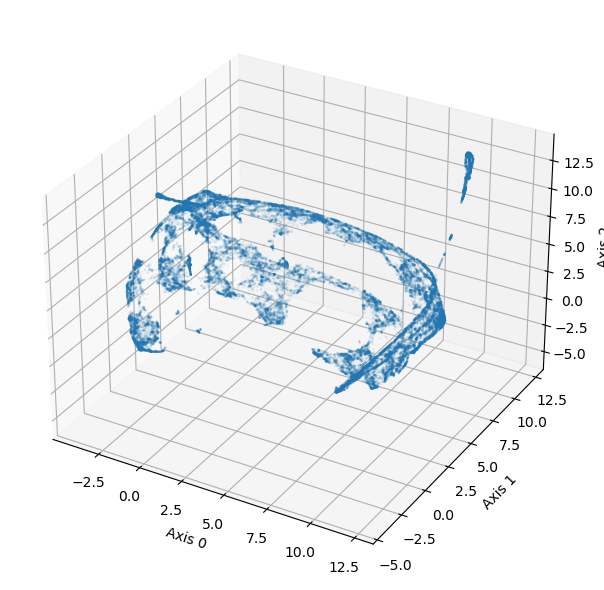

In [9]:
# visualize embedding
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.tight_layout()
plt.savefig("output/umap_space.png")
plt.show()

In [10]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 128,Total memory: 249.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37729,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 249.68 GiB
Comm: tcp://127.0.0.1:37943,Total threads: 32
Dashboard: http://127.0.0.1:32825/status,Memory: 62.42 GiB
Nanny: tcp://127.0.0.1:36589,


# KMeans

In [11]:
%%time
# compute scores 
scores_kmeans = conduct_exps(df=df_scaled, embedding=embedding, algorithm="kmeans", n_iterations=10)

compute clusters on original data, scores on original data
compute clusters on original data, scores on embedded data
compute clusters on embedded data, scores on original data
compute clusters on embedded data, scores on embedded data
CPU times: user 132 µs, sys: 1.01 ms, total: 1.14 ms
Wall time: 999 µs


In [12]:
%%time
results_kmeans = dask.compute(*scores_kmeans)

# runs on 4 workers, <2Gib per worker (bytes stored per worker) -> 1:30 h

CPU times: user 2min 31s, sys: 22.9 s, total: 2min 54s
Wall time: 1h 29min 47s


In [13]:
pd.concat(results_kmeans).to_csv("output/kmeans_scores.csv", index=False)

In [ ]:
# %%time
# # 1 iteration = 33min
# # 10 iterations = 4h 50min

# for i, exp in enumerate(scores_kmeans):
#     res = exp.compute()
#     res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/kmeans_scores_{i}.csv", index=False)

In [ ]:
# plot scores

# Agglomerative Ward clustering

In [11]:
%%time
scores_ward = conduct_exps(df=df_scaled, embedding=embedding, algorithm="ward", n_iterations=10)

compute clusters on original data, scores on original data
compute clusters on original data, scores on embedded data
compute clusters on embedded data, scores on original data
compute clusters on embedded data, scores on embedded data
CPU times: user 901 µs, sys: 0 ns, total: 901 µs
Wall time: 831 µs


In [12]:
%%time
results_ward = dask.compute(*scores_ward)

CPU times: user 9min 51s, sys: 1min 32s, total: 11min 24s
Wall time: 6h 46min 47s


beginning around 9Gib per worker, peaks up to 25Gib

CPU times: user 10min 15s, sys: 1min 31s, total: 11min 47s <br>
Wall time: 6h 47min 12s

In [13]:
pd.concat(results_ward).to_csv("output/ward_scores.csv", index=False)

In [ ]:
# %%time
# for i, exp in enumerate(scores_ward):
#     res = exp.compute()
#     res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/ward_scores_{i}.csv", index=False)

# DBSCAN

In [11]:
%%time
scores_dbscan = conduct_exps(df=df_scaled, embedding=embedding, algorithm="dbscan", n_iterations=10)

compute clusters on original data, scores on original data
compute clusters on original data, scores on embedded data
compute clusters on embedded data, scores on original data
compute clusters on embedded data, scores on embedded data
CPU times: user 1.26 ms, sys: 55 µs, total: 1.32 ms
Wall time: 1.08 ms


In [12]:
%%time
results_dbscan = dask.compute(*scores_dbscan)

Task exception was never retrieved
future: <Task finished name='Task-135' coro=<Client._gather.<locals>.wait() done, defined at /albedo/home/yvjennig/.conda/envs/cluster_validation/lib/python3.11/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/albedo/home/yvjennig/.conda/envs/cluster_validation/lib/python3.11/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-133' coro=<Client._gather.<locals>.wait() done, defined at /albedo/home/yvjennig/.conda/envs/cluster_validation/lib/python3.11/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/albedo/home/yvjennig/.conda/envs/cluster_validation/lib/python3.11/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task fin

KeyboardInterrupt: 

In [13]:
pd.concat(results_dbscan).to_csv("output/dbscan_scores.csv", index=False)

NameError: name 'results_dbscan' is not defined

In [ ]:
# %%time
# for i, exp in enumerate(scores_dbscan):
#     res = exp.compute()
#     res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/dbscan_scores_{i}.csv", index=False)